## Class 3 - L1 and L2 regularization
In our this lecture, we discussed some foundational concepts in data science, namely *overfitting*, the *bias-variance* trade-off, and *regularization*.
Today, we will apply some of these concepts to interpret and improve the performance of our predictive models, focusing especially on regularization.

AS usual, we will do all of this using `scikit-learn`.

**Note**: As last week, under `nbs/class_03` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on sample data.
Some of it repeats things done as part of `class_02`, for the sake of completeness.
But you can also:
- just keep working on the same notebook as last week
- work in a new notebook, but load data splits and models that have saved last week

### Today's exercise
Gather in the same group as last week, and please go through the following steps:
1. Look back at last week's notebook. If you have not applied any transformation to your input because you did not have time, spend some time thinking about whether it would make sense to do so. You can find relevant transformations in `scikit-learn`: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. You will probably mostly be interested in `StandardScaler` and `MinMaxScaler`
2. Look at the performance of the models you've fitted last week: what is the best model? Do you see any evidence of overfitting?
3. Fit your maximal models with `Lasso` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) and `Ridge` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) estimators instead of `LinearRegression`. Make sure you look at the documentation to understand what these do. Fit multiple models with multiple values of alpha and store the outputs;
4. Plot the performance of your models against your linear and KNN models from last week. Does the performance of the model on the validation set improve with regularization?
5. For both `Lasso` and `Ridge` models, plot the value of the coefficients as a function of alpha. You can access the coefficients for a fitted `model` through `model.coef_`. What do you notice in terms of how LASSO versus Ridge behave? (Look at `example.ipynb` for inspiration)
6. Finally, if any models are doing better than the linear model without regularization, select the best `Ridge` and the best `Lasso` model, and plot their coefficients, alongsize coefficients from the simple linear models. How do estimates change with regularization? Which values have changed the most? Do you have any hypothesis as to why?

### Once you have done this
Please submit a pull request to my repository where, within `nbs/class_03/group-x` you have the notebook on which you have worked.
If your notebook is the same as last week, please push that one.

In [1]:
import pandas as pd
import numpy as np
import json
import pickle

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_2628/3154562082.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load data

In [20]:
with open('../class_02/data/train_shuffle.pkl', 'rb') as file:
    X_train, y_train = pickle.load(file)

with open('../class_02/data/val_shuffle.pkl', 'rb') as file:
    X_val, y_val = pickle.load(file)

with open('../class_02/data/test_shuffle.pkl', 'rb') as file:
    X_test, y_test = pickle.load(file)

### Fit Lasso and Ridge regression on maximal models

In [21]:
# prepare X
X_train_sink = X_train.to_numpy()
X_val_sink = X_val.to_numpy()
X_test_sink = X_test.to_numpy()

# function for fitting and evaluating lasso and ridge models
def regularized_regression(X_train, y_train, X_val, y_val, X_test, y_test, alpha):

    models_alpha = {}

    sink_lasso = Lasso(alpha = alpha)
    models_alpha[f'lasso_{alpha}'] = sink_lasso
    sink_lasso.fit(X_train_sink, y_train)

    sink_ridge = Ridge(alpha = alpha)
    models_alpha[f'ridge_{alpha}'] = sink_ridge
    sink_ridge.fit(X_train_sink, y_train)

    performance_alpha = []

    # evaluate
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):

        preds_lasso = sink_lasso.predict(x)
        r2_lasso = r2_score(y, preds_lasso)
        rmse_lasso = np.sqrt(mean_squared_error(y, preds_lasso))

        performance_alpha.append({'model': f'sink_lasso_{alpha}',
                            'split': nsplit,
                            'rmse': rmse_lasso.round(4),
                            'r2': r2_lasso.round(4)})

        preds_ridge = sink_ridge.predict(x)
        r2_ridge = r2_score(y, preds_ridge)
        rmse_ridge = np.sqrt(mean_squared_error(y, preds_ridge))

        performance_alpha.append({'model': f'sink_ridge_{alpha}',
                            'split': nsplit,
                            'rmse': rmse_ridge.round(4),
                            'r2': r2_ridge.round(4)})
    
    return models_alpha, performance_alpha

# fit lasso and ridge models with different alpha values
models = {}
performance_lasso_ridge = []
for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:

    models_alpha, performance_alpha = regularized_regression(X_train_sink, y_train, X_val_sink, y_val, X_test_sink, y_test, alpha=alpha)

    models.update(models_alpha)
    performance_lasso_ridge.extend(performance_alpha)

# save performances
file_path = 'performances_lasso_ridge.txt'
with open(file_path, 'w') as file:
    json.dump(performance_lasso_ridge, file)


### Combine with performances from class 2

In [22]:
with open('../class_02/performances.txt', 'rb') as file:
    performances = json.load(file)

performances.extend(performance_lasso_ridge)

### Plot performances

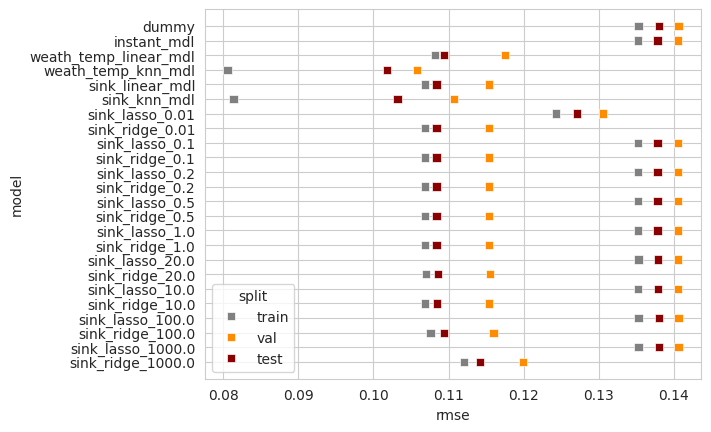

In [24]:
perf_df = pd.DataFrame(performances)
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df, 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['grey', 'darkorange', 'darkred'])
plt.show()

### Plot regularized coefficients

In [25]:
coefs = pd.DataFrame(np.vstack([v.coef_.round(4) for v in models.values()]),
                     columns=X_train.columns)
coefs['mtype'] = [k.split('_')[0] for k in models.keys()]
coefs['alpha'] = [float(k.split('_')[1]) for k in models.keys()]
coefs = pd.melt(coefs, id_vars=['mtype', 'alpha'])# turning data into long format 

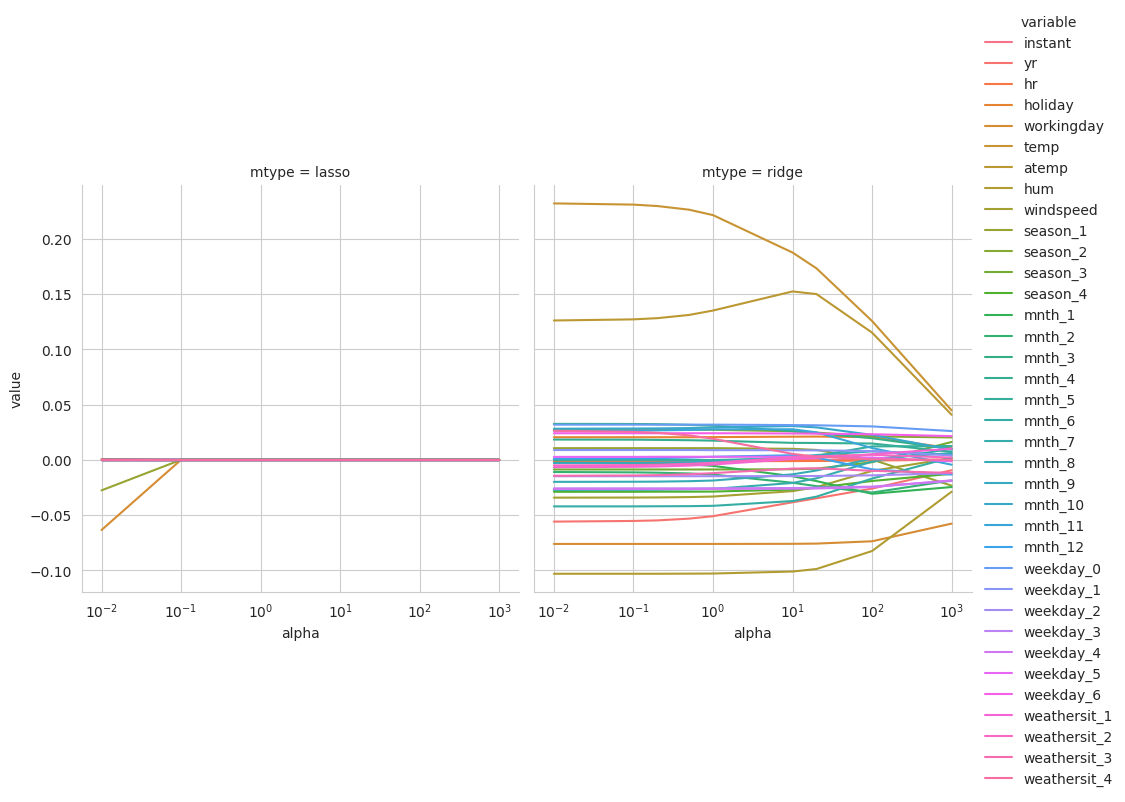

In [26]:
grid = sns.relplot(data=coefs, 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")